# Pump Design Throttling Verification

In [1]:
import math
import CoolProp.CoolProp as CP      # import CoolProp
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import bisect

def interpolate(data):
    x = np.array([point[0] for point in data])
    y = np.array([point[1] for point in data])

    # Fit a polynomial of degree len(data) - 1
    coeffs = np.polyfit(x, y, len(data) - 1)

    # Define the interpolation function using the polynomial coefficients
    def fun(x_val):
        return np.polyval(coeffs, x_val)

    return fun



# Create the interpolation function
m_dot_f = interpolate([(0.3, 0.093),(1, 0.2582)])
pt1_f = interpolate([(0.3, 3.3*1e5),(1, 3.38*1e5)])
pt3_f = interpolate([(0.3, 12.48*1e5),(1, 31.47*1e5)])
#dtp_f = interpolate([(0.3, 9.04*1e5),(1, 26.585*1e5)])


def throttle(fraction,n):

    precision = 0.05
    increment = 0.1

    # TBD
    k_s = 10*1e-6 # superficial roughness

    rho = 728.53 # [kg/m^3] fluid density (1)
    g = 9.81 # [m/s^2]

    T1 = 90 # [K] inlet temperature (2)
    m_dot = m_dot_f(fraction)  #0.186 # [kg/s] mass flow rate (3)
    V_des = 0.2582/rho
    n_des = 36137
    V = m_dot/rho # [m^3/s] volumetric flow rate (3)
    #print('V: ', V)

    H_des = 393.04 # for both stages
    W_des = 2598.398137443811 # for one stage
    P_des = V_des*rho*W_des

    #pt1 = 3.3*1e5 # [Pa] inlet total pressure (4)
    #pt3 = 12.34*1e5 # [Pa] outlet total pressure (5)

    pt1 = pt1_f(fraction)
    #pt3 = pt3_f(fraction)

    # Z_h = 1 # [m] head loss
    # W_ref = g*dH # [J/kg] reversible work
    # E_diss = g*Z_h # [J/kg] dissipation
    # W = W_ref + E_diss # [J/kg]
    #eta_hyd = W_ref/W # [-] hydraulic (reversible) efficiency

    #n = 38800 # [rpm] speed of rotation
    z = 2 # [-] number of stages

    V_opt = V_des*(n/n_des)
    F = q_star = V/V_opt # F = ((V/n)/(V_des/n_des))
    print('F: ', F)
    #print('q_star: ', q_star)

    H_opt = H_des*(n/n_des)**2
    #print('H_opt: ', H_opt)

    f_vaneless = -0.4557*F**3 + 5.1947*F**2 - 7.5361*F + 3.7971
    print('f_vaneless: ', f_vaneless)
    f_vaned = 0.6919*F**3 + 1.2428*F**2 - 6.3835*F + 5.4488
    print('f_vaned: ', f_vaned)

    Zh_vaneless = f_vaneless*44.88707516468211*(n/n_des)**2
    Zh_vaned = f_vaned*13.657239858121814*(n/n_des)**2

    #c_p_est = -1.5*F + 2.2
    c_p_est = 5.4965*F**6 - 24.7078*F**5 + 41.9486*F**4 - 33.7144*F**3 + 12.741*F**2 - 1.57325*F + 0.50935 + 0.05958
    #c_p_est =  5.4965*F**6 - 21.858*F**5 + 31.889*F**4 - 20.989*F**3 + 5.7256*F**2 - 0.025*F + 0.4609 
    #print('c_p_est: ', c_p_est)

    vanes = True # vaned (True) or vaneless diffuser (False)

    # initial values

    # 210 38800 F = 1    -> 237
    #           F = 1.4  -> 200
    #           F = 0.5  -> 290

    #     30000

    # 80  25000 F = 1 -> 100
    #           F = 0.5 -> 150
    #           F = 1.4 -> 70

    for dHs in range(300, -1, -1):
        try:
            # code
            for iii in range(1000):

                # Head and specific speed

                #dH = dtp/(rho*g)  # [m] pump head
                #dHs = dH/z # [m] stage head
                dH = dHs*z
                #print('dHs: ', dHs)
                omega_s = ((2*math.pi*n)/60)*(math.sqrt(V)/((g*dHs)**(3/4)))
                #print('omega_s:', omega_s)

                eta_hyd = 0.7

                eta_hyd_R = 0.9428222710350949

                eta_hyd_err = 1
                eta_hyd_R_err = 1

                n_it_eta = 0

                # initial values
                
                c_p = c_p_est

                while eta_hyd_err > 1e-4 or eta_hyd_R_err > 1e-4:

                    eta_hyd_old = eta_hyd
                    eta_hyd_R_old = eta_hyd_R

                    n_it_eta = n_it_eta + 1
                    #print()
                    #print('eta iteration', n_it_eta)

                    if n_it_eta > 100:
                        print('eta not converged')
                        break

                    #W = (g*dHs)/eta_hyd #Stage work [J/kg]

                    
                    #print ('W: ', W)

                    # Geometry

                    D_2 = 0.032168454294969215# (1)
                    delta_h = 0.25 # (2)
                    delta_t = 0.3302368204947847 # determined from delta_h

                    D_1h = delta_h*D_2
                    D_1t = delta_t*D_2
                    D_1M = (D_1t+D_1h)/2 # inlet mean diameter

                    b_2 = 0.001160400549246422 # blade height at rotor outlet (4)
                    b_1 = 0.0012905472464300651 # = (D_1t-D_1h/2), calculated from delta_h, delta_t

                    D_2_S = 0.03716845429496921 # based on D_2
                    b_2_S = 1.1*b_2
                    b_3 = b_2_S

                    D_3 = 0.03956009754495902 # based on D_2

                    beta_2B = 1.2965085818569233 # outlet blade angle (fixed) (5??), but not really used as input parameter, right?? 
                    Nb_R = 6 # fixed

                    Nb_S = 10

                    O_2_S = 0.0007286667776174573 # blade distance at the leading edge

                    # (Kinematic) Input Parameters (delta_h and delta_t fixed by geometry!)

                    alpha_1 = 0 # fixed by assumption (3)

                    u_2 = (D_2*math.pi*n)/60
                    #print("u_2: ", u_2)

                    #psi = 0.700566

                    W = W_des*(n/n_des)**2

                    #W = psi*(u_2)**2

                    P = m_dot*W

                    psi = W/(u_2**2)

                    A_1 = (math.pi/4)*((D_1t**2)-(D_1h**2))
                    c_1m = V/A_1 # correct? matches with calculated c_1m -> check also in design script
                    #print("c_1m: ", c_1m)

                    A_2 = b_2*math.pi*D_2
                    c_2m = V/A_2
                    #print("c_2m: ", c_2m)

                    # phi, psi, xi (R) have to be calculated/assumed!

                    phi = c_1m/u_2
                    #print('phi: ', phi)
                    xi = c_2m/(u_2*phi)
                    #print('xi: ', xi)
                    #psi = W/(u_2**2) # ???
                    #print("phi: ", phi)
                    #print("xi: ", xi)
                    #print("psi: ", psi)

                    # xi = math.sqrt(1-((2*psi)/phi**2)*(R+(psi/2)-1)+(math.tan(alpha_1)**2)*(1-delta_t**2)-((2*psi*delta_t)/phi)*math.tan(alpha_1))

                    # Rotor blade and flow angles (fixed or calculate???)

                    S_2_S = (math.pi*D_2_S)/Nb_S # blade pitch at stator inlet
                    
                    #alpha_2_S = math.acos(O_2_S/S_2_S) # flow angle at vaned diffuser inlet
                    #c_2_Su = math.tan(alpha_2_S)*c_2_Sm # absolute tangential velocity at the vaned diffuser inlet (assuming no friction?)
                    
                    #alpha_2 = math.atan((psi/(xi*phi))+((delta_t/xi)*math.tan(alpha_1)))
                    #alpha_2 = math.atan(c_2u/(u_2*xi*phi))

                    SF_des = 0.85164641274232
                    f_SF = 1.533544 - 0.6681668*F + 0.077472*F**2 + 0.0571508*F**3
                    #f_SF = 1.534988 - 0.6681668*F + 0.077472*F**2 + 0.0571508*F**3
                    #print('f_SF: ',f_SF)

                    SF = f_SF*SF_des

                    alpha_2 = math.atan(SF*((1/(xi*phi)) - math.tan(beta_2B)))
                    #print('alpha_2: ', alpha_2)
                    # from beta_2B = math.atan((1/(xi*phi))-(math.tan(alpha_2)/SF))
                
                    beta_1 = math.atan((delta_t/phi)-math.tan(alpha_1))
                    #print('beta_1: ', beta_1*(180/math.pi))
                    beta_2 =math.atan(((1/(phi*xi))*(1-psi))-((delta_t/xi)*math.tan(alpha_1)))
                    
                    # Kinematic parameters

                    c_1 = u_2*phi*math.sqrt(1+(math.tan(alpha_1)**2))
                    u_1 = u_2*delta_t

                    c_2 = u_2*xi*phi*math.sqrt(1+(math.tan(alpha_2)**2))
                    w_1 = u_2*phi*math.sqrt(1+(math.tan(beta_1)**2))
                    w_2 = u_2*xi*phi*math.sqrt(1+(math.tan(beta_2)**2))

                    c_1u = u_2*phi*math.tan(alpha_1)
                    w_1u = u_2*phi*math.tan(beta_1)
                    w_2u = u_2*xi*phi*math.tan(beta_2)
                    
                    #print("w_1: ", w_1)
                    #print("w_2: ", w_2)
                    #print("c_1: ", c_1)
                    #print("c_2: ", c_2)

                    c_3 = c_1

                    i = 2

                    
                    pt3 = dH*rho*g + pt1
                    dtp = pt3 - pt1 # total pressure difference [Pa]

                    p1 = (pt1 + (i-1)*(dtp/z)) - ((rho/2)*(c_1**2))
                    #print('p1: ', p1)
                    p2 = p1 + eta_hyd_R*(rho/2)*((u_2**2)-(u_1**2)+(w_1**2)-(w_2**2))
                    #print("p2: ", p2)
                    pt2 = p2 + ((rho/2)*(c_2**2))
                    #print('pt2: ', pt2)
                    pt2S = pt2 - (Zh_vaneless*rho*g)
                    #pt2S = pt3 + (Zh_vaned*rho*g)
                    #print('pt2s: ', pt2S)
                    p3 = (pt3 - (z-i)*(dtp/z)) - ((rho/2)*(c_3**2))
                    #print('p3: ', p3)
                    pt3s = pt3 - ((z-i)*(dtp/z))
                    #print('pt3s: ', pt3s) # stage pt3

                    Zh_vaned_calc = (pt2S-pt3s)/(rho*g)
                    #print('Zh_vand_calc, Zh_vaned: ', Zh_vaned_calc, Zh_vaned)

                    # initial values
                    c_2S = c_1*(D_2/D_1M) # absolute tangential velocity at the vaned diffuser inlet (assuming no friction?)
                    #print('initial c_2S: ', c_2S)
                    c_2S_old = c_2S + 0.1
                    n_it_c_2S = 0

                    while abs(c_2S-c_2S_old) > 1e-3:
                        n_it_c_2S = n_it_c_2S + 1
                        c_2S_old = c_2S
                        p2S = p3 - (c_p*0.5*rho*(c_2S**2))
                        #print('p2S: ',p2S)

                        c_2S = math.sqrt((2/rho)*(pt2S-p2S))

                        if n_it_c_2S > 50:
                            print('c_2S not converged!')
                            return (None, None, None, None, None, None, None, None, None)
                        
                    #print('c_2S: ', c_2S)
                    #print('p2S: ', p2S)
                    #print('p3:', p3)

                    c_2_Sm = V/(math.pi*D_2_S*b_2_S)

                    c_2_Su = math.sqrt((c_2S**2)-(c_2_Sm**2))
                    
                    alpha_2_S = math.atan(c_2_Su/c_2_Sm)
                    
                    c_2u = c_2_Su*(D_2_S/D_2)
                    #print('c_2u: ', c_2u)

                    alpha_1M = math.atan(math.tan(alpha_1)*(D_1t/D_1M)) # inlet mean absolute flow angle (fixed)
                    beta_1M = math.atan(((delta_t*D_1M)/(phi*D_1t))-math.tan(alpha_1M)) # inlet mean relative flow angle

                    beta_M = (beta_1M+beta_2B)/2

                    Lm_R = (D_2-D_1M)/2 # meridional channel length
                    L_hyd_R = Lm_R/math.cos(beta_M) # hydraulic length

                    S_1R = (math.pi*D_1M)/Nb_R # blade pitch at rotor inlet
                    S_2R = (math.pi*D_2)/Nb_R # blade pitch at rotor outlet
                    O_1 = S_1R*math.cos(beta_1M) # blade distance at leading edge
                    O_2 = S_2R*math.cos(beta_2B) # blade distance at trailing edge


                    # hydraulic diameters at inlet and outlet
                    D_hyd_1 = 2*((O_1*b_1)/(O_1+b_1))
                    D_hyd_2 = 2*((O_2*b_2)/(O_2+b_2))
                    D_hyd_R = (D_hyd_1+D_hyd_2)/2 # rotor hydraulic diameter

                    w_bar_R = (2*V)/(Nb_R*(O_1*b_1+O_2*b_2)) # rotor mean velocity
                    w_1M = c_1m/math.cos(beta_1M) # inlet mean relative velocity
                    w_1q = V/(Nb_R*O_1*b_1) # relative velocity at inlet cross sectional area (O_1*b_1)

                    # Stator blade and flow angles

                    c_3m = V/(math.pi*D_3*b_3)
                    #print('c_3m: ', c_3m)

                    if c_3m > c_3:
                        print ("Geometry not valid!")

                    alpha_3 = math.acos(c_3m/c_3)
                    #print('alpha_3: ', alpha_3, '=', alpha_3*(180/math.pi))
                    alpha_M = (alpha_2_S+alpha_3)/2

                    S_3 = (math.pi*D_3)/Nb_S # blade pitch at stator outlet

                    O_3 = S_3*math.cos(alpha_3) # blade distance at the trailing edge

                    D_hyd_2_S = 2*((O_2_S*b_2_S)/(O_2_S+b_2_S))
                    D_hyd_3 = 2*((O_3*b_3)/(O_3+b_3))

                    D_hyd_vaned = (D_hyd_2_S+D_hyd_3)/2

                    Lm_vaneless = (D_2_S-D_2)/2
                    Lm_vaned = (D_3-D_2_S)/2

                    # Stator hydraulic parameters
                    L_hyd_vaneless = Lm_vaneless
                    L_hyd_vaned = Lm_vaned/math.cos(alpha_M)

                    w_bar_vaneless = (2*V)/(Nb_R*O_2*b_2+Nb_S*O_2_S*b_2_S) # vaneless diffuser mean velocity (correct calculation?)
                    c_2Sq = V/(Nb_S*O_2_S*b_2_S) #Velocity at the cross sectional area (O_2S*b_2S)

                    A_R = (D_3*b_3*math.cos(alpha_3))/(D_2_S*b_2_S*math.cos(alpha_2_S))
                    r_eq = math.sqrt((D_2_S*math.cos(alpha_2_S)*b_2_S)/Nb_S)
                    A_R_opt = 1.05+(0.184*(L_hyd_vaned/r_eq))
                    #print('A_R = ', A_R, '=', A_R_opt, '= A_R_opt ?')

                    # state variables

                    p1 = (pt1 + (i-1)*(dtp/z)) - ((rho/2)*(c_1**2))
                    #print('p1: ', p1)
                    mu_1 = CP.PropsSI("V", "T", T1, "P", p1, "Propane") # [Pa*s]
                    #print("mu_1: ", mu_1)
                    p2 = p1 + eta_hyd_R*(rho/2)*((u_2**2)-(u_1**2)+(w_1**2)-(w_2**2))
                    #print("p2: ", p2)
                    # asumption: rho = const.
                    # alternative 1
                    c_2S = math.sqrt((c_2_Su**2)+(c_2_Sm**2))
                    p2S = p2 + (rho/2)*((c_2**2)-(c_2S**2)) - (Zh_vaneless*rho*g)
                    #print('p2S:', p2S)
                    # alternative 2 (no losses)
                        # momentum conservation
                    T2 = CP.PropsSI("T", "D", rho, "P", p2S, "Propane") # [K]
                    #print("T2: ", T2)
                    mu_2S = CP.PropsSI("V", "T", T2, "P", p2S, "Propane") # [Pa*s]
                    #print("mu_2S: ", mu_2S)
                    # Reynolds Numbers

                    Re_1 = (rho*w_1*D_hyd_R)/mu_1
                    Re_2S = (rho*c_2S*D_hyd_vaned)/mu_2S

                    ks_adm_R = D_hyd_R*(100/Re_1)
                    ks_adm_S = D_hyd_vaned*(100/Re_2S)

                    # rotor losses

                    # shock losses

                    #Zh_shock = 0.3*(((w_1M-w_1q)/u_2)**2)*((u_2**2)/(2*g))
                    # skin friction losses
                    # assumption (calculate differently?)
                    mu = mu_1
                    Re = (rho*w_bar_R*L_hyd_R)/mu # Reynolds number
                    #print('w_bar, L_hyd, Re (rotor):', w_bar_R, L_hyd_R, Re)
                    f_r = 0.136/((-math.log10((0.2*(k_s/L_hyd_R))+(12.5/Re)))**(2.15))
                    #print('f_r(rotor):', f_r)
                    f_sf = (f_r+0.0015)*(1.1+(4*(b_2/D_2))) # skin friction coefficient

                    #Zh_sf = 4*f_sf*(L_hyd_R/D_hyd_R)*((w_bar_R/u_2)**2)*((u_2**2)/(2*g)) # skin friction losses
                    #print('Zh_sf:', Zh_sf)
                    # Rotor losses
                    #Zh_R = Zh_shock + Zh_sf

                    Zh_R = 10.06284400520881*(n/n_des)**2

                    # stator losses

                    mu = mu_2S
                    Re = (rho*w_bar_vaneless*L_hyd_vaneless)/mu # Reynolds number
                    #print('w_bar, L_hyd, Re (stator):', w_bar_vaneless, L_hyd_vaneless, Re)
                    R_crit = 1e5 # or calculate with formula (see Gülich, value for Tu?)
                    if Re > R_crit:
                        f_r = 0.136/((-math.log10((0.2*(k_s/L_hyd_vaneless))+(12.5/Re)))**(2.15))
                    else:
                        f_r = (2.65/(Re**0.875))-(2/((8*Re)+(0.016/Re)))+(1.328/(math.sqrt(Re)))
                    #print('f_r(stator):', f_r)

                    # Zh_vaneless with downstream vaned diffuser

                    #f_L = 0.2292*F**3 + 0.6555*F**2 - 2.0738*F + 2.1891
                    #f_L = 1.8151- 1.83527*q_star + 0.8798*q_star**2 + 0.18765*q_star**3
                    #print('f_L: ', f_L)

                    f_sf= f_r+0.0015 # Skin friction coefficien
                    #Zh_vaneless = ((u_2**2)/(2*g))*f_sf*((O_2_S/D_2)+(b_2_S/D_2))*(((math.pi**3)*((c_2m/u_2)*(b_2/D_2))**2)/(8*(Nb_S*(O_2_S/D_2)*(b_2_S/D_2))**3))*(1+(c_2/c_2Sq))**3 # Losses vaneless diffusor
                    #Zh_vaneless = f_L*20.56

                    #print('Zh_vaneless:', Zh_vaneless)
                    # Zh_vaneless = 0 # set to zero if too high
                    # losses in vaned diffuse
                    #p3 = (pt3 - (z-i)*(dtp/z)) - ((rho/2)*(c_3**2))
                    #print('p3:', p3)
                    # c_p =(p3-p_2_S)/(0.5*rho*c_2s**2) # pressure recovery  coefficient

                    #p2S = p2 + (rho/2)*((c_2**2)-(c_2S**2)) - (Zh_vaneless*rho*g) # update p2S with calculated losses

                    c_p = (p3-p2S)/(0.5*rho*(c_2S**2))
                    #print('c_p: ', c_p)
                    c_p_opt = 0.36*((L_hyd_vaned/r_eq)**0.26)
                    #print('c_p_opt: ', c_p_opt)

                    error = Zh_vaned_calc - Zh_vaned

                    #c_pi = 1-(1/(A_R**2)) # ideal pressure recovery coefficient
                    #print('c_p, c_pi:', c_p, c_pi)
                    #A_R = (O_3*b_3)/(O_2_S*b_2_S) # area ratio
                    #Zh_vaned = ((u_2**2)/(2*g))*(((c_2Sq/u_2)**2)*((0.3*(((c_2/c_2Sq)-1)**2))+(c_pi-c_p))) # losses in vaned diffuser
                    #Zh_vaned = f_L*14.11
                    #print('Zh_vaned:', Zh_vaned)
                    # stator losses

                    Zh_S = Zh_vaneless + Zh_vaned
                    #Zh_S = 34.67*f_L

                    #Zh_S = f_L*34.67

                    Z_h = Zh_R + Zh_S

                    # Required Net Positive Suction Head Turbomachinery p.338
    
                    p1_1 = (pt1 + (1-1)*(dtp/z)) - ((rho/2)*(c_1**2))

                    #omega_s = omega *(V**0.5)/(g*delta_H)**(3/4) #Specific Speed
                    #omega_s = 0.27
                    lambda_c = -0.103*math.log(omega_s)+1.1855
                    lambda_w = 0.2144*math.exp(0.1745*omega_s)
                    w_1t = w_1
                    p_v_P = 9.7*1e-4
                    p_s = p1_1
                    c_s = c_1
        
                    NPSH_R = lambda_c*(c_1m**2)/(2*g)+lambda_w*(w_1t**2)/(2*g) # Required Net Positive Suction Head
                    #NPSH = ((p_s-p_v_Ox)/(rho*g))+((c_s**2)/(2*g)) # Net positive suction head
                    NPSH = ((p_s-p_v_P)/(rho*g))+((c_s**2)/(2*g))*(n/n_des)**2
                    #NPSH = 20.134*(n/n_des)**2
        
                    #print('NPSH_R =',NPSH_R)
                    #print('NPSH =',NPSH)
                    if NPSH > 1.25*NPSH_R and NPSH > (NPSH_R + 0.6):
                        cavitation = 1
                        #print('NPSH > NPSH_R, Cavitation avoided!)')
                    else:
                        cavitation = 0
                        #print('Error: NPSH <= NPSH_R, Caviation exists!')
                    
                    eta_hyd_R = 1-(Zh_R/((((u_2**2)-(u_1**2))/(2*g))+(((w_1**2)-(w_2**2))/(2*g))))
                    eta_hyd = 1-((g*Z_h)/W)

                    eta_hyd_R_err = abs(eta_hyd_R-eta_hyd_R_old)
                    eta_hyd_err = abs(eta_hyd-eta_hyd_old)

                    #print('eta_hyd: ', eta_hyd)
                    #print('eta_hyd_R: ', eta_hyd_R)

                print(iii, fraction ,n , F, eta_hyd, dH, psi, 2*W, 2*P, dtp, NPSH, NPSH_R, c_p, c_p_est, error, end='\r')
                print(alpha_2*(180/math.pi),beta_1*(180/math.pi),beta_2*(180/math.pi),c_1,c_1m,c_1u,u_1,w_1,w_1u,w_1q,w_1M,w_bar_R,c_2,c_2m,c_2u,u_2,w_2,w_2u,w_bar_vaneless,c_2S,c_2_Su,c_2_Sm,c_2Sq,c_3,mu_1,mu_2S,p1,p2,p2S,p3,Zh_vaneless,Zh_vaned,Zh_S,Zh_R,Z_h,W,P,eta_hyd,eta_hyd_R,end='\r')
                #, end='\r'
                #time.sleep(0.1)

                if abs(error) < precision:
                    break
                elif error > 0:
                    dHs += increment
                elif error < 0:
                    dHs -= increment

            return (n, c_p, dH, eta_hyd,eta_hyd_R, P, NPSH, NPSH_R, cavitation)
            
        except:
            pass
    print('Hat nicht geklappt :c')
    return (None, None, None, None, None, None, None, None, None)



In [2]:
# throttle(0.3,11180) <- natural throttle by speed control (dtp = 2.2 bar, W = 226, ...)
# throttle(0.3, 20620) <- final 0.3 operating point
throttle(0.3, 18930)
#throttle(1, 36137)

F:  0.6875878476002948
f_vaneless:  0.9231671331989251
f_vaned:  1.8720702037684394


(18930,
 0.7107929315465314,
 126.20000000000066,
 0.7090356282223602,
 0.9421277478337822,
 66.31101587587563,
 45.753073078066315,
 2.1686815972883595,
 1)

In [3]:
data = []

#n_range = [16000,20620,24300,28000,31500,35000,38800]
#n_range = [15000,18930,23700,28000,32000,36137]
n_range = np.arange(14628.25,40438.75,4301.75)
f_range = np.linspace(0.0,2.0,100)
for n in n_range:
    data_n = []
    for f in f_range:
        _, _, dH, eta_hyd,_,P,NPSH,NPSH_R,cavitation = throttle(f,n)
        data_n.append((dH,eta_hyd,P,NPSH,NPSH_R,cavitation))
    data.append(data_n)

F:  0.212400951688253
f_vaneless:  2.4264130869540628
f_vaned:  4.155636395701367
F:  0.25801622568809635750674055401 87.97745902303288 0.8053344373865852 0.8053344373865851 0.0 8.136669649365441 8.176426880914757 8.136669649365437 7.193418926169762 7.193418926169761 1.6929005906025403 28.189704753379402 0.25984690145892286 23.59490053272722 24.63889289260505 7.362631157531727 7.358044383507018 1.4841021920271358 20.421874733834077 20.42085133155815 0.2044469095152237 3.2762418558078172 0.8053344373865852 0.0074513301634357675 0.007361015691400651 611495.6636376865 801337.2244440318 811335.2909997858 896656.1477076856 17.84705671840435 9.299959012228221 27.14701573063257 1.6489264963635113 28.795942226996083 425.7809755089997 9.452337656299768 0.33654106337388323 0.941551860133862555
f_vaneless:  2.190659980108741
f_vaned:  3.896374163081113
F:  0.30363149968793964412185097333 87.54358279148576 0.9782882341135253 0.9782882341135253 0.0 8.136669649365441 8.195269419116718 8.136669649365

In [10]:
data


[[(79.79999999999974,
   0.33654106337388323,
   9.452337656299768,
   45.6666297746783,
   0.7900720660513902,
   1),
  (79.79999999999977,
   0.38986135836681257,
   11.482323721352778,
   45.68578827222838,
   0.8167240187202292,
   1),
  (79.79999999999977,
   0.4393853284838556,
   13.512309786405785,
   45.70239718943286,
   0.8480320797827304,
   1),
  (79.7999999999998,
   0.4851366361356868,
   15.542295851458794,
   45.71645652629171,
   0.8839956423572739,
   1),
  (79.39999999999982,
   0.5271389437329802,
   17.572281916511802,
   45.72796628280494,
   0.9246319416962427,
   1),
  (79.19999999999982,
   0.5654159136864095,
   19.602267981564815,
   45.73692645897255,
   0.9698925000272961,
   1),
  (78.79999999999984,
   0.5999912084066489,
   21.63225404661782,
   45.74333705479452,
   1.0197857646087347,
   1),
  (78.19999999999986,
   0.6308884903043728,
   23.662240111670833,
   45.74719807027089,
   1.0742894449227873,
   1),
  (77.39999999999985,
   0.658131421790254

In [ ]:
# Plot
plt.plot(x_values, dHs)
plt.plot(x_values, np.array(dHs)-10)
plt.xlabel('x')
plt.ylabel('dH')
plt.ylim(0,None)
plt.xlim(0,None)
plt.grid(True)
plt.show()

394.04000000000144


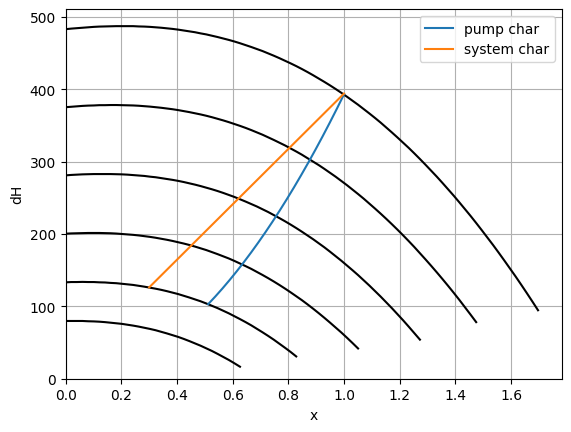

In [44]:
# Plot dH
for index, n in enumerate(n_range):
    dHs = []
    for index2, f in enumerate(f_range):
        dHs.append(data[index][index2][0])
    plt.plot(f_range,dHs, color = 'black')

# label=f'{n} rpm'

def f_H_opt(fraction):
    return 393.04*(fraction)**2

f_range_H_opt = np.linspace(0.512,1.0,20)

plt.plot(f_range_H_opt, f_H_opt(f_range_H_opt), label = 'pump char')

x = np.array([0.3, 1])
y = np.array([126.2, 394.04])

# Fit an exponential function through the points
# The exponential function has the form: y = a * exp(b * x)
# where 'a' and 'b' are coefficients to be determined
b, a = np.polyfit(x, np.log(y), 1)

# Define the exponential function
def exp_fun(x):
    return np.exp(a)*np.exp(b*x)

print(exp_fun(1))

plt.plot(x,exp_fun(x),label = 'system char')

plt.xlabel('x')
plt.ylabel('dH')
plt.ylim(0,None)
plt.xlim(0,None)
plt.grid(True)
plt.legend()
plt.show()

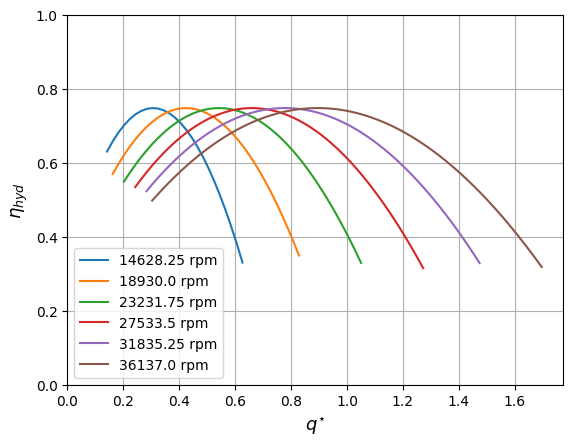

In [16]:
from matplotlib import colormaps

# Plot eta
for index, n in enumerate(n_range):
    etas = []
    n_des = 36136
    for index2, f in enumerate(f_range):
        if f*(n_des/n) < 0.3:
            etas.append(None)
        else:
            etas.append(data[index][index2][1])

    plt.plot(f_range,etas,label=f'{n} rpm')

plt.xlabel('$q^{\star}$', size = 13)
plt.ylabel('${\eta}_{hyd}$', size = 13)
plt.ylim(0,1)
plt.xlim(0,None)
plt.grid(True)
plt.legend()
plt.show()

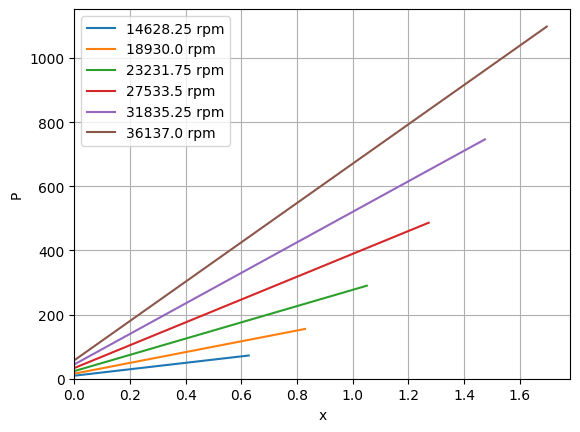

In [12]:
# Plot eta
for index, n in enumerate(n_range):
    Ps = []
    for index2, f in enumerate(f_range):
        Ps.append(data[index][index2][2])
    plt.plot(f_range,Ps,label=f'{n} rpm')

plt.xlabel('x')
plt.ylabel('P')
plt.ylim(0,None)
plt.xlim(0,None)
plt.grid(True)
plt.legend()
plt.show()

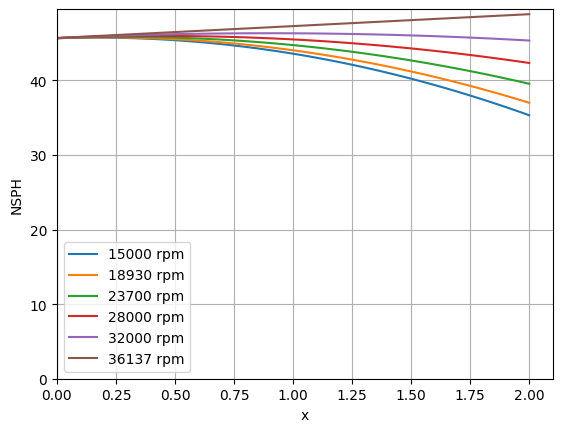

In [116]:
# Plot eta

#f_range_NPSH = f_range

for index, n in enumerate(n_range):
    NPSHs = []
    f_range_NPSH = f_range
    for index2, f in enumerate(f_range):
        if data[index][index2][3] != None:
            NPSHs.append(data[index][index2][3])
        else:
            index3 = np.where(f_range_NPSH == f)
            f_range_NPSH = np.delete(f_range_NPSH,index3)
    #print(f_range_NPSH.size)
    #print(len(NPSHs))
    d, c, b, a = np.polyfit(f_range_NPSH, NPSHs, 3)
    # Define the polynomial
    def NPSH_fun(x):
        return a + b*x + c*x**2 + d*x**3
    #plt.plot(f_range, NPSH_fun(f_range),label=f'{n} rpm', linestyle = ls, linewidth = lw)
    plt.plot(f_range, NPSH_fun(f_range),label=f'{n} rpm')
    #ls=['-','--','-.',':'][index%4]
    #lw=10-8*index/len(n_range)
    
#print(f_range_NPSH.size)
#print(f_range_NPSH)
#print(NPSHs.size)
#print(NPSHs)

#plt.plot(f_range,NPSHs,label=f'{n} rpm', linestyle = ls, linewidth = lw)



plt.xlabel('x')
plt.ylabel('NSPH')
plt.ylim(0,None)
plt.xlim(0,None)
plt.grid(True)
plt.legend()
plt.show()

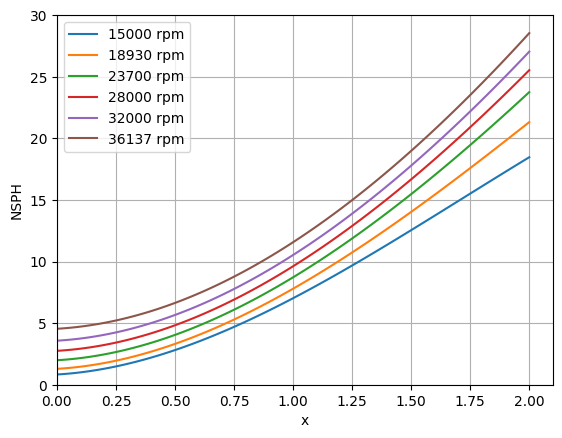

In [117]:
# Plot eta
#for index, n in enumerate(n_range):
#    NPSHRs = []
#    for index2, f in enumerate(f_range):
#        NPSHRs.append(data[index][index2][4])
#    plt.plot(f_range,NPSHRs,label=f'{n} rpm')

for index, n in enumerate(n_range):
    NPSHrs = []
    f_range_NPSHr = f_range
    for index2, f in enumerate(f_range):
        if data[index][index2][4] != None:
            NPSHrs.append(data[index][index2][4])
        else:
            index3 = np.where(f_range_NPSHr == f)
            f_range_NPSHr = np.delete(f_range_NPSHr,index3)
    #print(f_range_NPSHr.size)
    #print(len(NPSHrs))
    d, c, b, a = np.polyfit(f_range_NPSHr, NPSHrs, 3)
    # Define the polynomial
    def NPSHr_fun(x):
        return a + b*x + c*x**2 + d*x**3
    #plt.plot(f_range, NPSH_fun(f_range),label=f'{n} rpm', linestyle = ls, linewidth = lw)
    plt.plot(f_range, NPSHr_fun(f_range),label=f'{n} rpm')
    #ls=['-','--','-.',':'][index%4]
    #lw=10-8*index/len(n_range)

plt.xlabel('x')
plt.ylabel('NSPH')
plt.ylim(0,30)
plt.xlim(0,None)
plt.grid(True)
plt.legend()
plt.show()

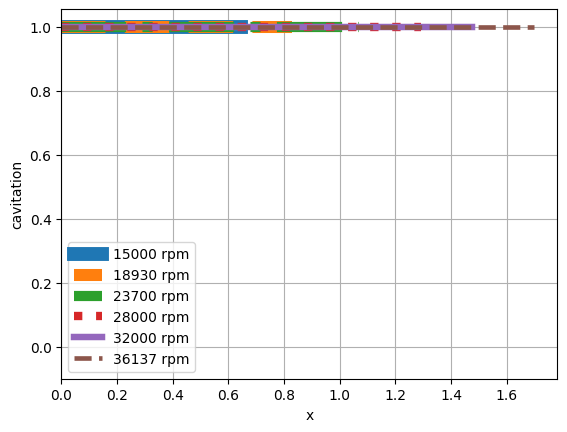

In [118]:
# Plot eta
for index, n in enumerate(n_range):
    cav = []
    for index2, f in enumerate(f_range):
        cav.append(data[index][index2][5])
    ls=['-','--','-.',':'][index%4]
    lw=10-8*index/len(n_range)
    plt.plot(f_range,cav,label=f'{n} rpm', linestyle = ls, linewidth = lw)

plt.xlabel('x')
plt.ylabel('cavitation')
plt.ylim(-0.1,None)
plt.xlim(0,None)
plt.grid(True)
plt.legend()
plt.show()

intersections: [2.71718267 2.58706273 2.57592322 2.62708825 2.73534002 2.91014509]
inter:  [1.0999149718517502, 1.3552065074488733, 1.6560091967279034, 2.001630861571103, 2.4097250278338778, 2.9101450935456423]
14628.25
[14628.25 18930.   23231.75 27533.5  31835.25 36137.  ]
(array([0], dtype=int64),)
18930.0
[18930.   23231.75 27533.5  31835.25 36137.  ]
(array([0], dtype=int64),)
23231.75
[23231.75 27533.5  31835.25 36137.  ]
(array([0], dtype=int64),)
27533.5
[27533.5  31835.25 36137.  ]
(array([0], dtype=int64),)
31835.25
[31835.25 36137.  ]
(array([0], dtype=int64),)
36137.0
[36137.]
(array([0], dtype=int64),)
t_dhs:  []
n_range_inter:  []
qs_NPSH:  [1.09991497 1.35520651 1.6560092  2.00163086 2.40972503]


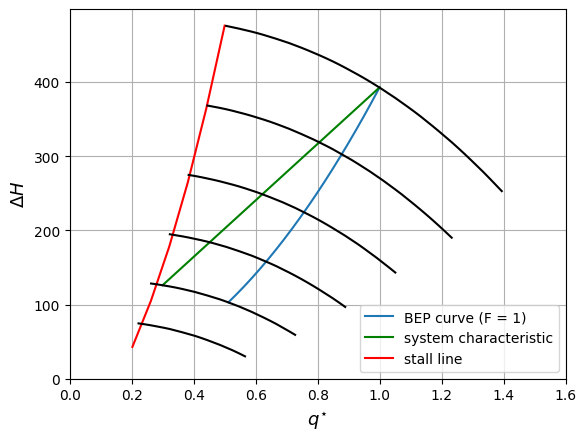

In [7]:
from scipy.interpolate import interp1d
from scipy.optimize import bisect

#print(f_range)

# label=f'{n} rpm'

def f_H_opt(fraction):
    return 393.04*(fraction)**2

f_range_H_opt = np.linspace(0.512,1.0,20)

plt.plot(f_range_H_opt, f_H_opt(f_range_H_opt), label = 'BEP curve (F = 1)')

x = np.array([0.3, 1])
y = np.array([126.2, 393.04])

# Fit an exponential function through the points
# The exponential function has the form: y = a * exp(b * x)
# where 'a' and 'b' are coefficients to be determined
b, a = np.polyfit(x, np.log(y), 1)

# Define the exponential function
def exp_fun(x):
    return np.exp(a)*np.exp(b*x)

#print(exp_fun(1))

plt.plot(x,exp_fun(x),label = 'system characteristic', color = 'green')

target_f = 0.5 # specify the target value in f_range

# Initialize dHs for the target n value
target_dHs = None
t_dHs = []

for index, n in enumerate(n_range):
    # Extract values from the data for the current n
    data_values = data[index]
    # Interpolate to find the value of dHs for the target f
    interpolation_function = interp1d(f_range, [entry[0] for entry in data_values], kind='linear', fill_value="extrapolate")
    target_dHs = float(interpolation_function(target_f))
    t_dHs.append(target_dHs)
    # Once we find the target n value, we don't need to continue searching

#print(t_dHs)


def q_f_06(n):
    rho = 728.53
    V_des = 0.2582/rho
    n_des = 36137
    F = 0.5
    V_opt = V_des*(n/n_des)
    V = F*V_opt
    q_star = V/V_des
    return q_star

qs = []

for index, n in enumerate(n_range):
    qs.append(q_f_06(n))

#print('qs: ', qs)

plt.plot(qs,t_dHs, color = 'red', label = 'stall line')

#################################################

intersections = np.array([])

for index, n in enumerate(n_range):
    NPSHrs = []
    NPSHs = []
    f_range_NPSHr = f_range
    f_range_NPSH = f_range
    for index2, f in enumerate(f_range):
        if data[index][index2][4] != None:
            NPSHrs.append(data[index][index2][4])
        else:
            index3 = np.where(f_range_NPSHr == f)
            f_range_NPSHr = np.delete(f_range_NPSHr,index3)

    for index2, f in enumerate(f_range):
        if data[index][index2][3] != None:
            NPSHs.append(data[index][index2][3])
        else:
            index3 = np.where(f_range_NPSH == f)
            f_range_NPSH = np.delete(f_range_NPSH,index3)
    
    #print(f_range_NPSHr.size)
    #print(len(NPSHrs))
    #print(f_range_NPSH.size)
    #print(len(NPSHs))
    d, c, b, a = np.polyfit(f_range_NPSHr, NPSHrs, 3)
    h, g, f, e = np.polyfit(f_range_NPSH, NPSHs, 3)
    # Define the polynomial
    def NPSHr_fun(x):
        return a + b*x + c*x**2 + d*x**3
    
    def NPSH_fun(x):
        return e + f*x + g*x**2 + h*x**3
    
    def difference(x):
        return NPSHr_fun(x) - NPSH_fun(x)
    
    # Define a range of x values
    x_values = np.linspace(0, 3, 1000)
    
    # Find intersections
    for i in range(len(x_values) - 1):
        x1, x2 = x_values[i], x_values[i+1]
        if difference(x1) * difference(x2) < 0:
            intersection = bisect(difference, x1, x2)
            intersections = np.append(intersections,intersection)
    

print('intersections:',intersections)
# Initialize dHs for the target n value
target_dHs_NPSH = None
t_dHs_NPSH = []

def q_f_06_NPSH(n,ind,inters):
    rho = 728.53
    V_des = 0.2582/rho
    n_des = 36137
    F = inters[ind]
    V_opt = V_des*(n/n_des)
    V = F*V_opt
    q_star = V/V_des
    return q_star

t_dhs = []
inter =[]
for index, n in enumerate(n_range):
    inter.append(q_f_06_NPSH(n,index,intersections))
#inter = intersections
    
print('inter: ',inter)

n_range_inter = n_range

for index, n in enumerate(n_range):
    f_range_dH = f_range
    dH_red = []
    # Extract values from the data for the current n
    for index2, f in enumerate(f_range):
        if data[index][index2][0] != None:
            dH_red.append(data[index][index2][0])
        else:
            index4 = np.where(f_range_dH == f)
            f_range_dH = np.delete(f_range_dH,index4)
    #print(dH_red)
    #print(f_range_dH.size)
    #print(len(dH_red))
    #data_values = data[index]
    target_f_NPSH = intersections[index]
    m, l, k, j = np.polyfit(f_range_dH, dH_red, 3)
    def dH_fun(x):
       return j + k*x + l*x**2 + m*x**3
    
    #x_val = np.linspace(0,2,30)
    #plt.plot(x_val,dH_fun(x_val))
    #print(dH_fun(1.3))
    #np.exp(j)*np.exp(k*x)
    #j + k*x + l*x**2 + m*x**3
    # Interpolate to find the value of dHs for the target f
    #interpolation_function = interp1d(f_range_dH, dH_red, kind='previous', fill_value="extrapolate")
    #target_dHs_NPSH = float(interpolation_function(target_f_NPSH))
    #t_dHs_NPSH.append(target_dHs_NPSH)
    if dH_fun(inter[index]) >= 0:
        t_dhs.append(dH_fun(inter[index]))
    #if target_dHs_NPSH >= 0:
    #    t_dhs.append(target_dHs_NPSH)
    else:
        index5 = np.where(inter == intersections[index])
        inter = np.delete(inter,index5)
        print(n)
        print(n_range_inter)
        index6 = np.where(n_range_inter == n_range[index])
        print(index6)
        n_range_inter = np.delete(n_range_inter, index6)
    # Once we find the target n value, we don't need to continue searching

#n_range_inter = np.delete(n_range_inter,0)

#print(t_dHs_NPSH)
print('t_dhs: ',t_dhs)
print('n_range_inter: ', n_range_inter)

#inter = np.delete(inter,0)

qs_NPSH = []

#for index, n in enumerate(n_range_inter):
    #qs_NPSH.append(q_f_06_NPSH(n,index,inter))

qs_NPSH = inter

print('qs_NPSH: ', qs_NPSH)

#plt.plot(qs_NPSH,t_dhs, color = 'red')
    
    #plt.plot(f_range, NPSH_fun(f_range),label=f'{n} rpm', linestyle = ls, linewidth = lw)
    #plt.plot(f_range, NPSHr_fun(f_range),label=f'{n} rpm')
    #ls=['-','--','-.',':'][index%4]
    #lw=10-8*index/len(n_range)

#print(f_range)

# Plot dH
for index, n in enumerate(n_range):
    dHs = []
    n_des = 36137
    for index2, f in enumerate(f_range):
        #print(f*(n_des/n),'>',intersections[index])
        if f*(n_des/n) < 0.5 or f*(n_des/n) > intersections[index] or f*(n_des/n) > 1.4:
            dHs.append(None)
        else:
            dHs.append(data[index][index2][0])
    plt.plot(f_range,dHs, color = 'black')

####################################################

#f_cav = []
#
#for index, n in enumerate(n_range):
#    for index2, f in enumerate(f_range):
#        if data[index][index2][5] == 0:
#            f_cav.append(f)
#            break
#
#print(f_cav)
#
#cav_target_dHs = None
#cav_t_dHs = []
#
#for index, n in enumerate(n_range):
#    cav_target_f = f_cav[index]
#    # Extract values from the data for the current n
#    data_values = data[index]
#    # Interpolate to find the value of dHs for the target f
#    interpolation_function = interp1d(f_range, [entry[0] for entry in data_values], kind='previous', fill_value="extrapolate")
#    target_dHs = float(interpolation_function(cav_target_f))
#    t_dHs.append(cav_target_dHs)
#    # Once we find the target n value, we don't need to continue searching
#
#print(cav_t_dHs)

#########################################################

#x = n_range
#y = np.array([80.7, 237.3])

# Fit an exponential function through the points
# The exponential function has the form: y = a * exp(b * x)
# where 'a' and 'b' are coefficients to be determined
#b, a = np.polyfit(x, np.log(y), 1)

# Define the exponential function
#def exp_fun(x):
#    return np.exp(a)*np.exp(b*x)

#################################################

plt.xlabel('$q^{\star}$', size = 13)
plt.ylabel('$\Delta H$', size = 13)
plt.ylim(0,None)
plt.xlim(0,1.6)
plt.grid(True)
plt.legend()
plt.show()

    

In [ ]:
# troubleshoot cp_est
x_values = np.linspace(0, 1.4, 100)

def cp_old(F):
    return 5.4965*F**6 - 21.858*F**5 + 31.889*F**4 - 20.989*F**3 + 5.7256*F**2 - 0.025*F + 0.4609

def cp_new(F):
    return (5.4965*F**6 - 24.7078*F**5 + 41.9486*F**4 - 33.7144*F**3 + 12.741*F**2 - 1.57325*F + 0.50935)/0.7088202460762562

def f_vaneless(F):
    return -0.4557*F**3 + 5.1947*F**2 - 7.5361*F + 3.7971

def f_vaned(F):
    return 0.6919*F**3 + 1.2428*F**2 - 6.3835*F + 5.4488

def f_SF(F):
    return 1.533544 - 0.6681668*F + 0.077472*F**2 + 0.0571508*F**3

# Plot
#plt.plot(x_values, cp_old(x_values))
plt.plot(x_values, cp_new(x_values), label = 'c_p')
plt.plot(x_values, f_vaneless(x_values), label = 'f_vaneless')
plt.plot(x_values, f_vaned(x_values),label = 'f_vaned')
plt.plot(x_values, f_SF(x_values), label = 'f_SF')

plt.xlabel('F')
plt.ylabel('val/val_des')
plt.grid(True)
plt.ylim(0,None)
plt.xlim(0,1.4)
plt.legend()
plt.show()

In [ ]:
# Plot
plt.plot(x_values, ns)
plt.xlabel('x')
plt.ylabel('n [rpm]')
plt.grid(True)
plt.show()

In [ ]:
# Plot
plt.plot(x_values, eta_hyds)
plt.xlabel('x')
plt.ylabel('eta_hyds')
plt.grid(True)
plt.show()

In [ ]:
# Plot
plt.plot(x_values, eta_hyd_Rs)
plt.xlabel('x')
plt.ylabel('throttle(x)')
plt.title('Throttle Function')
plt.grid(True)
plt.show()

In [ ]:
# Plot
plt.plot(x_values, dHs)
plt.xlabel('x')
plt.ylabel('throttle(x)')
plt.title('Throttle Function')
plt.grid(True)
plt.show()

## Cavitation

In [ ]:
# Required Net Positive Suction Head Turbomachinery p.338

#omega_s = omega *(V**0.5)/(g*delta_H)**(3/4) #Specific Speed
#omega_s = 0.27
#lambda_c = -0.103*math.log(omega_s)+1.1855
#lambda_w = 0.2144*math.exp(0.1745*omega_s)
#w_1t = w_1 = 24.93 #Equal?
#p_v_Ox = 0.9803*1e5
#p_s = p1 = 3.256*1e5
#c_s = c_1 = 2.776 #TBD?
#c_1m = 2.776
#
#
#NPSH_R = lambda_c*(c_1m**2)/(2*g)+lambda_w*(w_1t**2)/(2*g) # Required Net Positive Suction Head
#NPSH = (p_s-p_v_Ox)/(rho*g)+c_s**2/(2*g) # Net positive suction head
#
#print('NPSH_R =',NPSH_R)
#print('NPSH =',NPSH)
#if NPSH > NPSH_R:
#    print('NPSH > NPSH_R, Cavitation avoided!)')
#else:
#    print('Error: NPSH <= NPSH_R, Caviation exists!')

### External losses (not in iteration)

"are expressed as head losses contributing to the shaft power"

In [ ]:
# external losses

In [ ]:
# W, eta_hyd, eta_hyd_R (close loop)

## Clarify

- beta_2B iteration
- c_3, c_3m and alpha_3 iteration

- total vs. static pressures

- assumption for b2S and D2S (no friction in vaneless diffuser, not updated with losses?) -> alpha_2S -> losses -> no feedback
- assumption b3 = b2S (differs from Gülich?)

- cp CAN NOT be theoretically calculated (according to Gülich, p.28/29)? -> assume plane diffuser? or ideal pressure recovery? -> calculate A_R from this? -> how to do iteration then? (calculate b3? what about alpha_3?)


- first stage phi as input, c_1 = c_1m (alpha_1 = 0) = c_3 (previous stage) -> calculate phi
- eta_hyd > eta_hyd_R ?? (check dH calculation, c_1 = c_1 first stage and c_3 = c_3 (last stage))
